<a href="https://colab.research.google.com/github/ncsu-landscape-dynamics/LAMP_assay_automation/blob/main/Model_to_green_value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Base libraries
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import cv2
import pycocotools
import warnings
import sys

## Torch libraries
import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype
import torchvision.transforms.functional as F
#from torchvision.utils import draw_segmentation_masks

# Torch libraries from further out on the path
#from vision.references.detection import utils
#from vision.references.detection import transforms
#from vision.references.detection import coco_eval
#from vision.references.detection import engine
#from vision.references.detection import coco_utils
#
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
##

Mounted at /content/drive


In [2]:
%%shell

# Download TorchVision repo to use some functions from
# references/detection
git clone https://github.com/John-Polo/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 29554, done.
remote: Counting objects: 100% (2096/2096), done.
remote: Compressing objects: 100% (555/555), done.
remote: Total 29554 (delta 1562), reused 1996 (delta 1502), pack-reused 27458
Receiving objects: 100% (29554/29554), 37.77 MiB | 23.23 MiB/s, done.
Resolving deltas: 100% (22177/22177), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


The following messages is returned from running the model (a few cells forward from here):

**/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)**

John forked the Torch repo to keep the functions as the were at the time this code was originally written. Will periodically check the functions for updates.

In [3]:
# This list is here because of the model. These are all the classes the pre-
# trained model uses. It's possible that the whole list isn't necessary, but I'm
# not sure. It doesn't hurt anything to keep. Definitely need at least the first 
# two items. As the model is refined and more classes are added, may have to 
# change the classes. The first class in the original list is "person", not well,
# so I would change the object directly until I know better.
coco_names = [
    '__background__', 'well', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Necssary for a later code section. Since it uses "coco_names" directly, just
# thought I'd put it here.
color_n = np.random.uniform(0, 255, size=(len(coco_names), 3))

In [4]:
# This lets model and other settings choose between a CPU and GPU. If there is a
# GPU available for true Torch abilities, it will use CUDA, the protocol for GPU.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the model from the saved file:
model = torch.load('/content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection/four_chambers/model/MaskInstanceModel.pth', map_location=device)
model.load_state_dict(torch.load('/content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection/four_chambers/model/MaskModelParams.pth', map_location=device))
#model.to(device)

<All keys matched successfully>

In [ ]:
#The output from this can be cleared from the screen. Don't know how to do that.
model.eval()

The model returns a **Dict[Tensor]** during training, containing the classification and regression losses for both the RPN and the R-CNN, and the mask loss.

During inference, the model requires only the input tensors, and returns the post-processed predictions as a **List[Dict[Tensor]]**, one for each input image. The fields of the Dict are as follows, where N is the number of detected instances:

        boxes (FloatTensor[N, 4]): the predicted boxes in [x1, y1, x2, y2]
         format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.

        labels (Int64Tensor[N]): the predicted labels for each instance

        scores (Tensor[N]): the scores or each instance

        masks (UInt8Tensor[N, 1, H, W]): the predicted masks for each
         instance, in 0-1 range. In order to obtain the final segmentation
         masks, the soft masks can be thresholded, generally with a value
         of 0.5 (mask >= 0.5)



In [6]:
# Where are the new images that need to be analyzed store?
img_dir = input("Please provide a directory path that has the images awaiting\
 analysis.")

try:
    os.path.exists(img_dir) == False
except:
    sys.exit("The path provided does not exist. Do you need to provide a\
    leading '/' (on Windows, you need to provide 'C:\' instead).")

os.chdir(img_dir)
print(os.getcwd())

# Just base name of file
waiting_images = list()
# Complete path of files
w_im_dir_read = list()

for file in os.listdir("."):
    if file.endswith(".png"):
        waiting_images.append( file)
        w_im_dir_read.append(os.path.join( os.getcwd(), file))
    
waiting_images = sorted(waiting_images)
w_im_dir_read = sorted(w_im_dir_read)
        
# Some code here to sort the images and make sure that the 00 and 61 are treated consecutively.

# Check for even number of images. Otherwise, a 00 or 61 is probably missing.
try:
    len(waiting_images) % 2 == 0
except:
    sys.exit("Error: odd number of images. Is there a 0 min. image and a 61\
     min. image for each assay?")


# Create pairs of images (batches) for the image analysis.
no_pairs = int(len(waiting_images)/2)

img_count = 0

Please provide a directory path that has the images awaiting analysis./content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection/four_chambers/imgs_centercropped
/content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection/four_chambers/imgs_centercropped


In [7]:
waiting_images = waiting_images[0:4]
w_im_dir_read = w_im_dir_read[0:4]
waiting_images

['set10_00m.png', 'set10_61m.png', 'set11_00m.png', 'set11_61m.png']

In [ ]:
# Need a way to check if image have been processed or not. Have to set up a 
# tracking table.

In [8]:
no_pairs = int(len(waiting_images)/2)

img_count = 0
batch_int = list()
batch = list()

for i in range(no_pairs):
    img_pair = img_count,img_count+1
    # "read_image" is the Torchvision version of image ingestion.
    zero_im = read_image(w_im_dir_read[img_pair[0]])
    sixt_im = read_image(w_im_dir_read[img_pair[1]])
    # Switch the inputs to the right environment.
    zer_d_im = zero_im.to(device)
    six_d_im = sixt_im.to(device)
    # Next two statements are for later (optional) plotting.
    # Change Torch-based image read to shape that plt can render. (4,1600,1600) 
    # to (1600,1600,4) 
    z_im_perm = zero_im.permute(1,2,0)
    s_im_perm = sixt_im.permute(1,2,0)
    # Gather inputs for batches. The model is run on each batch for the 
    # comparison.
    batch_int.append(torch.stack([zer_d_im, six_d_im]))
    batch.append(convert_image_dtype(batch_int[i], dtype=torch.float))

In [11]:
# Creates outputs from the model that can be used with other functions and 
# classes created later on. 
# This will grab the first of the pair of images to be compared.
def get_first_outputs(image, model, threshold):
    with torch.no_grad():
        # forward pass of the image through the modle
        outputs = model(image)
    
    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]
    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    labels = [coco_names[i] for i in outputs[0]['labels']]
    return masks, boxes, labels

In [12]:
# Creates outputs from the model that can be used with other functions and 
# classes created later on. 
# This will provide the second of the pair of images to be compared.
def get_second_outputs(image, model, threshold):
    with torch.no_grad():
        # forward pass of the image through the modle
        outputs = model(image)
    
    # get all the scores
    scores = list(outputs[1]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[1]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]
    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[1]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    labels = [coco_names[i] for i in outputs[1]['labels']]
    return masks, boxes, labels

In [ ]:
# Run the model on the list of batches
mod_res = list()
for b in range(len(batch)):
    mod_res.append(get_first_outputs(batch[b], model, 0.9))
    mod_res.append(get_second_outputs(batch[b], model, 0.9))

len(mod_res), mod_res

In [ ]:
# Need both statements
mask_zero, boxes_zero, labels_zero = get_first_outputs(batch, model, 0.9)
mask_sixt, boxes_sixt, labels_sixt = get_second_outputs(batch, model, 0.9)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [53]:
mask_z_composite = list()
mask_s_composite = list()
mask_z_comp_num = list()
mask_s_comp_num = list()
mask_z_mult = list()
mask_s_mult = list()
z_img_mask_comp = list()
s_img_mask_comp = list()

for i,j in zip(range(0,len(mod_res),2),range(1,len(mod_res),2)):
    mask_z_composite.append(mod_res[i][0].sum(axis=0) > 0))
    mask_s_composite.append(mod_res[j][0].sum(axis=0) > 0))
    mask_z_comp_num.append(mask_z_composite*1)
    mask_s_comp_num.append(mask_s_composite*1)
    mask_z_mult.append(np.stack((mask_z_comp_num, mask_z_comp_num, mask_z_comp_num), axis=-1))
    mask_s_mult.append(np.stack((mask_s_comp_num, mask_s_comp_num, mask_s_comp_num), axis=-1))
    z_img_mask_comp.append(z_im_perm*mask_z_mult)
    s_img_mask_comp.append(s_im_perm*mask_s_mult)

0 1
2 3


In [ ]:
# masks is Boolean. Making a copy for zero and sixty minute sets.
mask_z = mask_zero
mask_s = mask_sixt

# This is a logical operation to get the various subsections of the masks 
# flattened down to a single array (layer or channel in an imagery sense).
mask_z_composite = mask_z.sum(axis=0) > 0
mask_s_composite = mask_s.sum(axis=0) > 0

# Change the Boolean from T/F to 1/0
mask_z_comp_num = mask_z_composite*1
mask_s_comp_num = mask_s_composite*1

# To run the next function, the mask needs to have 3 channels/layers/arrays.
mask_z_mult = np.stack((mask_z_comp_num, mask_z_comp_num, mask_z_comp_num), axis=-1)
mask_s_mult = np.stack((mask_s_comp_num, mask_s_comp_num, mask_s_comp_num), axis=-1)

# This requires multiplying 3 channels from each objects.
z_img_mask_comp = z_im_perm*mask_z_mult
s_img_mask_comp = s_im_perm*mask_s_mult

In [ ]:
# Get values of green channels, after dividing the np.ndarrays into sections
def green_cn(x):
    if type(x) == torch.Tensor:
        #print(f"{x} is a Tensor. Changed to np.array")
        x = x.detach().cpu().numpy()
    elif type(x) == PIL.Image.Image:
        #print(f"{x} is a PIL.Image. Changed to np.array")
        x = np.array(x)
    # x is an np.ndarray!
    width, height = x.shape[0:2]
    # set halves
    v_half = height//2
    h_half = width//2
    #split the halves into the quarters
    up_l_gr = x[:v_half,:h_half,1]
    up_r_gr = x[:v_half,h_half+1:,1]
    lw_l_gr = x[v_half+1:,:h_half,1]
    lw_r_gr = x[v_half+1:,h_half+1:,1]
    uplg_mean = up_l_gr[np.nonzero(up_l_gr)].mean()
    uprg_mean = up_r_gr[np.nonzero(up_r_gr)].mean()
    lwlg_mean = lw_l_gr[np.nonzero(lw_l_gr)].mean()
    lwrg_mean = lw_r_gr[np.nonzero(lw_r_gr)].mean()
    return lwlg_mean,uplg_mean,uprg_mean,lwrg_mean

In [ ]:
z_WI_gr,z_WII_gr,z_WIII_gr,z_WIV_gr = green_cn(z_img_mask_comp)
s_WI_gr,s_WII_gr,s_WIII_gr,s_WIV_gr = green_cn(s_img_mask_comp)

z_WI_gr,z_WII_gr,z_WIII_gr,z_WIV_gr, "|", s_WI_gr,s_WII_gr,s_WIII_gr,s_WIV_gr

(109.02999448524076,
 104.59019731677517,
 119.53931072709112,
 101.50113528646695,
 '|',
 169.8761493099509,
 178.64842885795903,
 183.52950669275236,
 164.88257657931274)

In [ ]:
z_1 = green_cn(z_img_mask_comp)
s_1 = green_cn(s_img_mask_comp)

In [ ]:
def threshold_test(z,s):
    z_threshold = np.mean(z)+3*np.std(z)
    if s[1] <= z_threshold:
        Pi_status = "negative"
    else:
        Pi_status = "positive"
    if s[2] <= z_threshold:
        TSWV_status = "negative"
    else:
        TSWV_status = "positive"
    if s[3] <= z_threshold:
        NC_status = "negative"
    else:
        NC_status = "positive"
    status_list=list([dict(Assay_level=z_threshold), 
                      dict(P_infestans_status_and_score=[Pi_status, s[1]]), 
                      dict(TSWV_status_and_score=[TSWV_status,s[2]]), 
                      dict(NC_status_and_score=[NC_status,s[3]])])

    return status_list

In [ ]:
threshold_result = threshold_test(z_1,s_1)

{'Assay_level': 129.13940829741722,
 'NC_status_and_score': ['positive', 164.88257657931274],
 'P_infestans_status_and_score': ['positive', 178.64842885795903],
 'TSWV_status_and_score': ['positive', 183.52950669275236]}

In [ ]:
# Add something like "image {}" later
print('Results after modeling {} and {} are:\n{} \n{} \n{} \n{}'.format(waiting_images[0],
                                                                        waiting_images[2],
                                                                        threshold_resul[0], 
                                                              threshold_resul[1], 
                                                              threshold_resul[2], 
                                                              threshold_resul[3])) 

In [ ]:
# Optional plotting. Good for a sanity check.
def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1 
    beta = 0.4 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    for i in range(len(masks)):
        red_map = np.zeros_like(masks[i]).astype(np.uint8)
        green_map = np.zeros_like(masks[i]).astype(np.uint8)
        blue_map = np.zeros_like(masks[i]).astype(np.uint8)
        # apply a randon color mask to each object
        color = color_n[random.randrange(0, len(color_n))]
        red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        #convert the original PIL image into NumPy format
        image = np.array(image)
        # convert from RGN to OpenCV BGR format
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # apply mask on the image
        cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
        # draw the bounding boxes around the objects
        cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, 
                      thickness=2)
        # put the label text above the objects
        cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 
                    thickness=2, lineType=cv2.LINE_AA)
    
    return image

# Example drawing
results = draw_segmentation_map(z_im_perm, mask_zero, boxes_zero, labels_zero)

In [ ]:
# Optional plotting. Good for a sanity check
def segmentation_plotting(original_image, segmentation_result):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(original_image)
    plt.subplot(1,2,2)
    plt.imshow(segmentation_result)

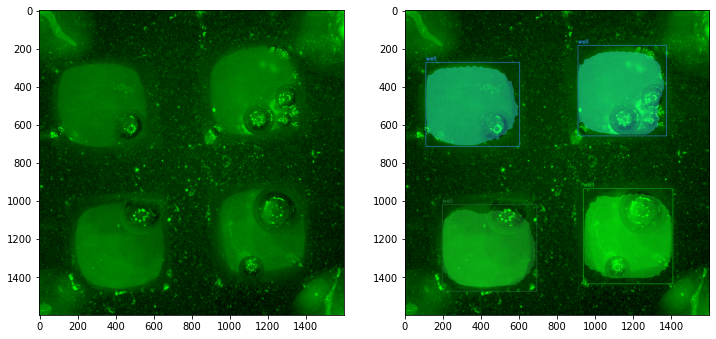

In [ ]:
# Optional plotting. Good for a sanity check.
segmentation_plotting(z_im_perm, results)

In [ ]:
# More optional plotting II. 

# Break images up into four sections.
def four_cn(x):
    if type(x) == torch.Tensor:
        x = x.detach().cpu().numpy()
    elif type(x) == PIL.Image.Image:
        #print(f"{x} is a PIL.Image")
        exit
    # x is an np.ndarray!
    width, height = x.shape[0:2]
    # set halves
    v_half = height//2
    h_half = width//2
    #split the halves into the quarters
    up_lf = x[:v_half,:h_half,:]
    up_rt = x[:v_half,h_half+1:,:]
    lw_lf = x[v_half+1:,:h_half,:]
    lw_rt = x[v_half+1:,h_half+1:,:]
    return lw_lf,up_lf,up_rt,lw_rt

def four_cn_image(x):
    if type(x) == torch.Tensor:
        x = x.detach().cpu().numpy()
        x = Image.fromarray(np.uint8(x))
    elif type(x) == np.ndarray:
        x = Image.fromarray(np.uint8(x))
    image = x
    width, height = image.size
    #set dividers and bottom halves
    v_half = height//2
    h_half = width//2
    #split the halves into the quarters
    up_lf = image.crop((0,0,h_half,v_half))
    up_rt = image.crop((h_half+1,0,width,v_half))
    lw_lf = image.crop((0,v_half+1,h_half,height))
    lw_rt = image.crop((h_half+1,v_half+1,width,height))
    return lw_lf,up_lf,up_rt,lw_rt

# Example
w1,w2,w3,w4 = four_cn(z_img_mask_comp)

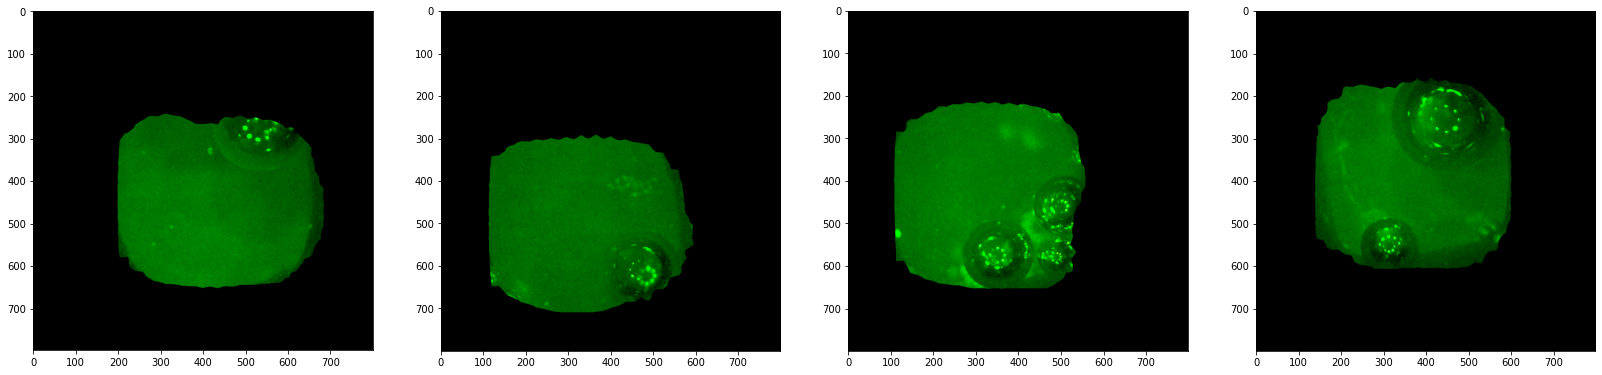

In [ ]:
# Optional plotting II.
plt.figure(figsize = (28,7))
plt.subplot(1,4,1)
plt.imshow(w1)
plt.subplot(1,4,2)
plt.imshow(w2)
plt.subplot(1,4,3)
plt.imshow(w3)
plt.subplot(1,4,4)
plt.imshow(w4)

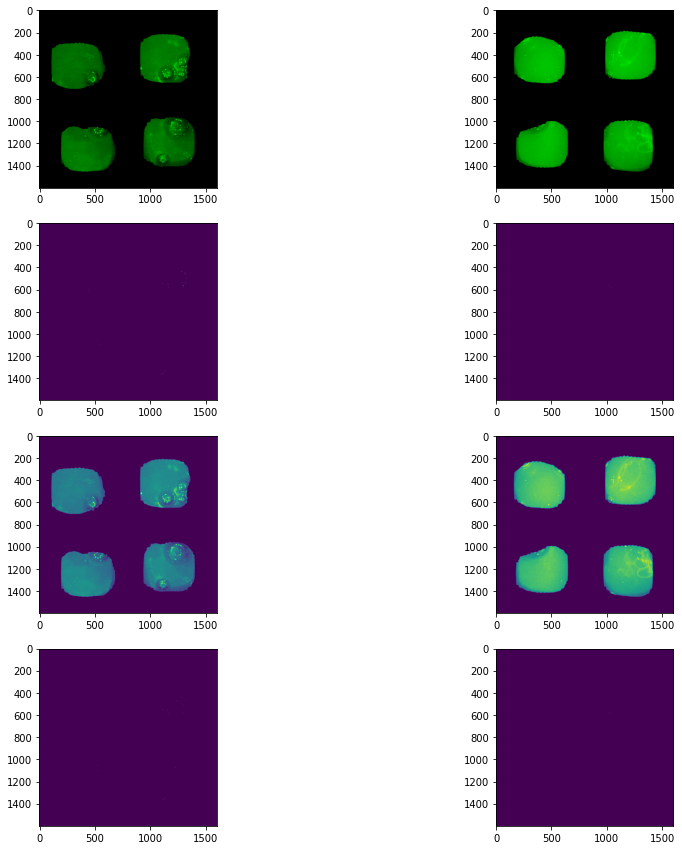

In [ ]:
# Completely optional III. Doesn't even make for sanity check.
plt.figure(figsize=(15,15))
plt.subplot(4,2,1)
plt.imshow(z_img_mask_comp)
plt.subplot(4,2,2)
plt.imshow(s_img_mask_comp)
plt.subplot(4,2,3)
plt.imshow(z_img_mask_comp[:,:,0])
plt.subplot(4,2,4)
plt.imshow(s_img_mask_comp[:,:,0])
plt.subplot(4,2,5)
plt.imshow(z_img_mask_comp[:,:,1])
plt.subplot(4,2,6)
plt.imshow(s_img_mask_comp[:,:,1])
plt.subplot(4,2,7)
plt.imshow(z_img_mask_comp[:,:,2])
plt.subplot(4,2,8)
plt.imshow(s_img_mask_comp[:,:,2])